# Лекция 3: Векторизация и косинусное расстояние

Ноутбук показывает:
1. Что такое cosine similarity / cosine distance
2. Классическую векторизацию: Count, Hashing, TF-IDF
3. Векторизацию на ML: Word2Vec
4. Современный подход: SentenceTransformer

In [ ]:
!pip install -q numpy pandas matplotlib scikit-learn gensim sentence-transformers

## Расстояние: косинусная близость и косинусное расстояние

### Что это
- **Cosine similarity** измеряет, насколько векторы направлены в одну сторону.
- **Cosine distance** обычно задают как `1 - cosine_similarity`.

### Формулы

Косинусное сходство (**Cosine Similarity**) определяет угол между двумя векторами $A$ и $B$:

$$ \text{cosine\_similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}} $$

Косинусное расстояние (**Cosine Distance**) дополняет сходство до единицы:

$$ \text{cosine\_distance}(A, B) = 1 - \text{cosine\_similarity}(A, B) $$

### Зачем это нужно
- Удобно сравнивать тексты как векторы признаков.
- Метрика не зависит от длины текста

In [15]:
import numpy as np

# Пример на числах: считаем cosine similarity и distance вручную

A = np.array([2, 1, 0, 1], dtype=float)
B = np.array([1, 1, 1, 0], dtype=float)

dot = np.dot(A, B)
norm_a = np.linalg.norm(A)
norm_b = np.linalg.norm(B)
cos_sim = dot / (norm_a * norm_b)
cos_dist = 1 - cos_sim

print("A:", A)
print("B:", B)
print("Скалярное произведение A·B:", dot)
print("||A||:", round(norm_a, 4), "||B||:", round(norm_b, 4))
print("Cosine similarity:", round(cos_sim, 4))
print("Cosine distance:", round(cos_dist, 4))

A: [2. 1. 0. 1.]
B: [1. 1. 1. 0.]
Скалярное произведение A·B: 3.0
||A||: 2.4495 ||B||: 1.7321
Cosine similarity: 0.7071
Cosine distance: 0.2929


## Векторизация текста

Векторизация переводит текст в числовой формат.

Ниже один и тот же набор предложений сравнивается разными методами:
- `CountVectorizer`
- `HashingVectorizer`
- `TfidfVectorizer`

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

texts = [
    "кошка спит на диване",
    "кот отдыхает на диване",
    "курс доллара растет"
]
labels = ["S1", "S2", "S3"]

print("Данные:")
for lbl, t in zip(labels, texts):
    print(f"{lbl}: {t}")

Данные:
S1: кошка спит на диване
S2: кот отдыхает на диване
S3: курс доллара растет


### CountVectorizer
Идея: считаем частоты слов (bag of words).

In [17]:
count_vec = CountVectorizer()
X_count = count_vec.fit_transform(texts)

count_vocab = count_vec.get_feature_names_out()
count_df = pd.DataFrame(X_count.toarray(), index=labels, columns=count_vocab)
count_sim = cosine_similarity(X_count)
count_sim_df = pd.DataFrame(count_sim, index=labels, columns=labels)

print("Словарь признаков CountVectorizer:")
print(list(count_vocab))
print("\nМатрица частот:")
display(count_df)
print("Cosine similarity:")
display(count_sim_df)

Словарь признаков CountVectorizer:
['диване', 'доллара', 'кот', 'кошка', 'курс', 'на', 'отдыхает', 'растет', 'спит']

Матрица частот:


,диване,доллара,кот,кошка,курс,на,отдыхает,растет,спит
S1,1,0,0,1,0,1,0,0,1
S2,1,0,1,0,0,1,1,0,0
S3,0,1,0,0,1,0,0,1,0


Cosine similarity:


,S1,S2,S3
S1,1.0,0.5,0.0
S2,0.5,1.0,0.0
S3,0.0,0.0,1.0


### HashingVectorizer
Идея: признаки получаются хешированием слов (без явного словаря).

Плюсы: быстро, удобно на больших потоках данных.
Минус: возможны коллизии (разные слова попадают в один и тот же индекс).

In [18]:
hash_vec = HashingVectorizer(n_features=16, alternate_sign=False, norm=None)
X_hash = hash_vec.transform(texts)

hash_df = pd.DataFrame(X_hash.toarray(), index=labels)
hash_sim = cosine_similarity(X_hash)
hash_sim_df = pd.DataFrame(hash_sim, index=labels, columns=labels)

print("Хеш-матрица признаков (показываем 16 измерений):")
display(hash_df)
print("Cosine similarity:")
display(hash_sim_df)

Хеш-матрица признаков (показываем 16 измерений):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
S1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
S2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
S3,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cosine similarity:


,S1,S2,S3
S1,1.0,0.5,0.0
S2,0.5,1.0,0.0
S3,0.0,0.0,1.0


### TF-IDF
Идея: важность слова = TF * IDF.

- TF: частота слова в документе
- IDF: штраф для слишком частых слов и усиление редких

Обычно TF-IDF лучше Count, когда нужно уменьшить влияние "служебных" частых слов.

In [19]:
tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(texts)

tfidf_vocab = tfidf_vec.get_feature_names_out()
idf_df = pd.DataFrame({"term": tfidf_vocab, "idf": tfidf_vec.idf_}).sort_values("idf", ascending=False)
tfidf_df = pd.DataFrame(X_tfidf.toarray(), index=labels, columns=tfidf_vocab)
tfidf_sim = cosine_similarity(X_tfidf)
tfidf_sim_df = pd.DataFrame(tfidf_sim, index=labels, columns=labels)

print("IDF веса:")
display(idf_df)
print("TF-IDF матрица:")
display(tfidf_df)
print("Cosine similarity:")
display(tfidf_sim_df)

IDF веса:


,term,idf
1,доллара,1.693147
2,кот,1.693147
3,кошка,1.693147
4,курс,1.693147
6,отдыхает,1.693147
7,растет,1.693147
8,спит,1.693147
0,диване,1.287682
5,на,1.287682


TF-IDF матрица:


,диване,доллара,кот,кошка,курс,на,отдыхает,растет,спит
S1,0.428046,0.00000,0.000000,0.562829,0.00000,0.428046,0.000000,0.00000,0.562829
S2,0.428046,0.00000,0.562829,0.000000,0.00000,0.428046,0.562829,0.00000,0.000000
S3,0.000000,0.57735,0.000000,0.000000,0.57735,0.000000,0.000000,0.57735,0.000000


Cosine similarity:


,S1,S2,S3
S1,1.000000,0.366447,0.0
S2,0.366447,1.000000,0.0
S3,0.000000,0.000000,1.0


,method,S1 vs S2 (близко),S1 vs S3 (несвязано)
0,Count,0.500000,0.0
1,Hashing,0.500000,0.0
2,TF-IDF,0.366447,0.0


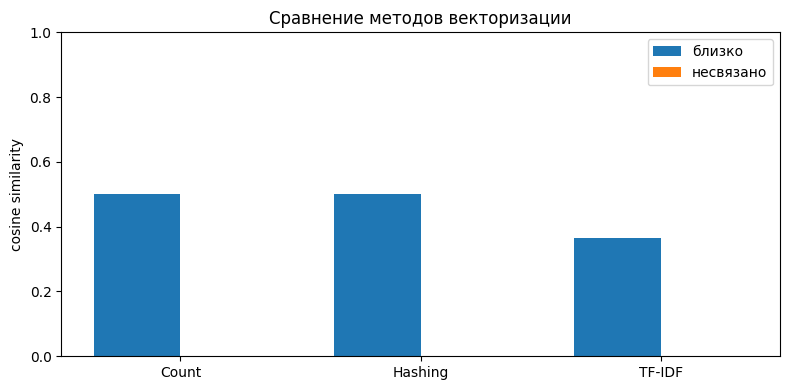

In [8]:
# Сводное сравнение близкой и несвязанной пары
summary = pd.DataFrame({
    "method": ["Count", "Hashing", "TF-IDF"],
    "S1 vs S2 (близко)": [count_sim[0, 1], hash_sim[0, 1], tfidf_sim[0, 1]],
    "S1 vs S3 (несвязано)": [count_sim[0, 2], hash_sim[0, 2], tfidf_sim[0, 2]]
})
display(summary)

x = np.arange(len(summary))
w = 0.36

plt.figure(figsize=(8, 4))
plt.bar(x - w/2, summary["S1 vs S2 (близко)"], w, label="близко")
plt.bar(x + w/2, summary["S1 vs S3 (несвязано)"], w, label="несвязано")
plt.xticks(x, summary["method"])
plt.ylim(0, 1)
plt.ylabel("cosine similarity")
plt.title("Сравнение методов векторизации")
plt.legend()
plt.tight_layout()
plt.show()

## Векторизация на ML: Word2Vec

### Методология
1. Готовим корпус и токенизируем его.
2. Обучаем модель (Skip-gram или CBOW).
3. Получаем эмбеддинги слов.
4. Для эмбеддинга предложения часто используют среднее по векторам слов.
5. Сравниваем предложения через cosine similarity.

Смысл: слова с похожим контекстом оказываются близко в векторном пространстве.

In [9]:
from gensim.models import Word2Vec

train_tokens = [
    ["кошка", "спит", "на", "диване"],
    ["кот", "отдыхает", "на", "диване"],
    ["кот", "лежит", "дома"],
    ["курс", "доллара", "вырос"],
    ["курс", "валют", "снизился"]
]

w2v = Word2Vec(sentences=train_tokens, vector_size=50, window=3, min_count=1, sg=1, seed=42, epochs=300)

print("Ближайшие слова к 'кот':")
for word, score in w2v.wv.most_similar("кот", topn=5):
    print(f"  {word:12s} -> {score:.3f}")

print("\nБлижайшие слова к 'курс':")
for word, score in w2v.wv.most_similar("курс", topn=5):
    print(f"  {word:12s} -> {score:.3f}")

Ближайшие слова к 'кот':
  кошка        -> 0.352
  на           -> 0.227
  отдыхает     -> 0.114
  диване       -> 0.112
  вырос        -> 0.112

Ближайшие слова к 'курс':
  отдыхает     -> 0.133
  вырос        -> 0.046
  диване       -> -0.011
  лежит        -> -0.016
  снизился     -> -0.020


In [10]:
# Сравнение предложений через усреднение Word2Vec-векторов
def sent_vector(text, model):
    tokens = text.lower().split()
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    if not vecs:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

S = np.vstack([sent_vector(t, w2v) for t in texts])
w2v_sim = cosine_similarity(S)
w2v_sim_df = pd.DataFrame(w2v_sim, index=labels, columns=labels)

print("Word2Vec sentence similarity:")
display(w2v_sim_df)

Word2Vec sentence similarity:


,S1,S2,S3
S1,1.000000,0.597126,-0.035047
S2,0.597126,1.000000,-0.003158
S3,-0.035047,-0.003158,1.000000


## Трансформер (SentenceTransformer)

Трансформер - современный подход, где эмбеддинг строится с учетом контекста всей фразы.

Коротко:
- лучше работает на семантическом поиске и сопоставлении фраз,
- обычно точнее классических методов,
- требует более тяжелую модель и ресурсы.

In [14]:
from sentence_transformers import SentenceTransformer

# При первом запуске модель скачивается из интернета
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

emb = model.encode(texts)
st_sim = cosine_similarity(emb)
st_sim_df = pd.DataFrame(st_sim, index=labels, columns=labels)

print("SentenceTransformer similarity:")
display(st_sim_df)

Loading weights: 100%|█| 199/199 [00:00<00:00, 2358.1
BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


SentenceTransformer similarity:


,S1,S2,S3
S1,1.000000,0.906671,-0.136121
S2,0.906671,1.000000,-0.117793
S3,-0.136121,-0.117793,1.000000


## Итог
- Cosine similarity помогает сравнивать тексты как векторы.
- Count/Hashing/TF-IDF - базовые и полезные методы.
- Word2Vec - шаг к смысловым представлениям через контекст слов.
- SentenceTransformer - современный контекстный подход для задач семантики.